<a href="https://colab.research.google.com/github/skytmddus27/president_election/blob/master/Smilegate_AI_UnSmile_dataset_fine_tuning_tutorial_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Smilegate UnSmile Dataset Tutorial

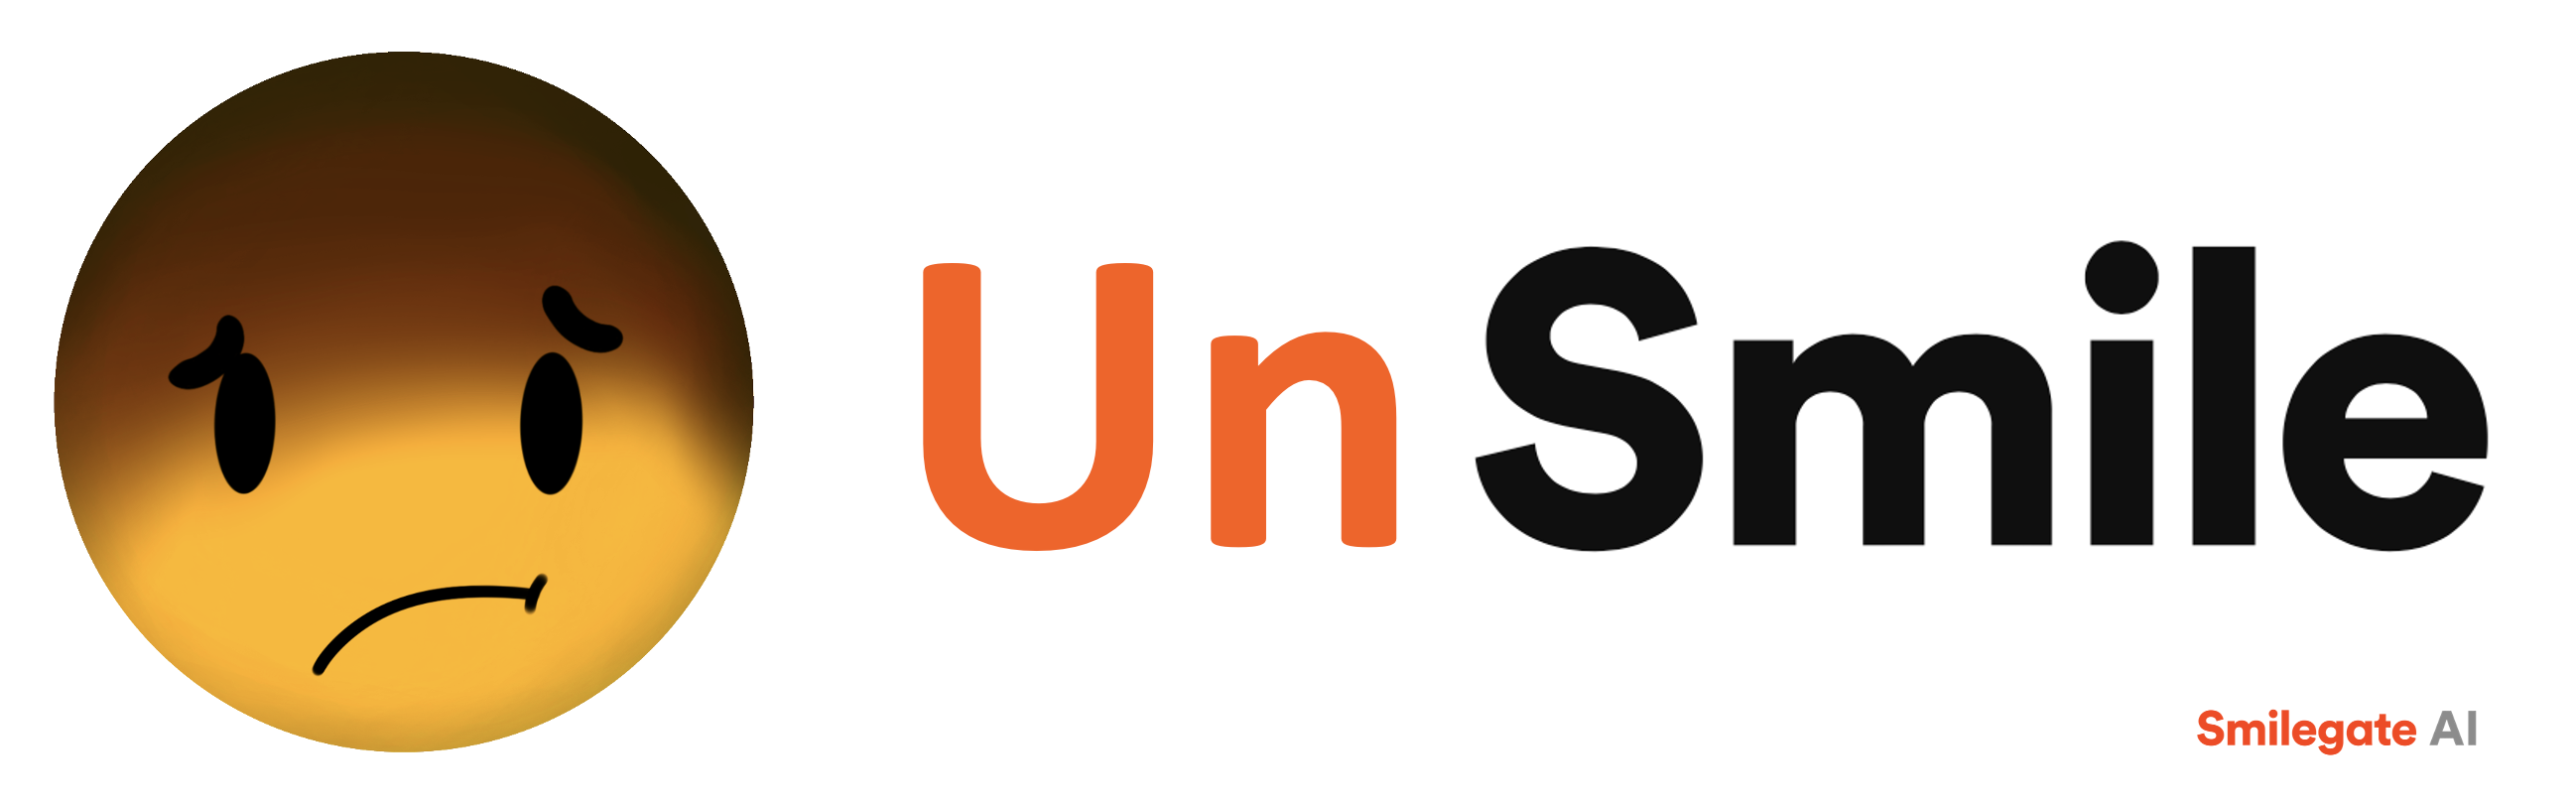

[Smilegate AI 센터](https://smilegate.ai) 에서 공개하는 한국어 혐오표현 "☹️ [UnSmile](https://github.com/smilegate-ai/korean_unsmile_dataset)" 데이터셋 사용을 위한 tutorial 실습 노트북입니다.

> Contact      
```
* 김성현 (seonghkim@smilegate.com)  
```

Smilegate AI `UnSmile`의 `소스코드 및 baseline 모델`은 [Apache 2.0](LICENSE.apache-2.0) 라이선스 하에 공개되어 있습니다. 

# 0. 환경설정

본 실습에서는 Huggingface [Transformers](https://github.com/huggingface/transformers)와 [Datasets](https://github.com/huggingface/datasets) 라이브러리를 사용합니다.

In [ ]:
!pip install transformers
!pip install datasets==1.17.0

# 1. 데이터셋 load

Huggingface Datasets를 통해 데이터를 load해보겠습니다.

In [2]:
from datasets import load_dataset

In [3]:
dataset = load_dataset('smilegate-ai/kor_unsmile')

Downloading:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

Using custom data configuration smilegate-ai--kor_unsmile-1dba960877497f9f


  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/290k [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/smilegate-ai--kor_unsmile-1dba960877497f9f/0.0.0/1638526fd0e8d960534e2155dc54fdff8dce73851f21f031d2fb9c2cf757c121. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
dataset["train"][0]

{'clean': 1,
 'labels': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 '개인지칭': 0,
 '기타 혐오': 0,
 '남성': 0,
 '문장': '일안하는 시간은 쉬고싶어서 그런게 아닐까',
 '성소수자': 0,
 '악플/욕설': 0,
 '여성/가족': 0,
 '연령': 0,
 '인종/국적': 0,
 '종교': 0,
 '지역': 0}

In [5]:
unsmile_labels = ["여성/가족","남성","성소수자","인종/국적","연령","지역","종교","기타 혐오","악플/욕설","clean"]
# 개인지칭의 경우, 추가 정보이므로 분류 대상에서 제외했습니다.

# 2. Model load

학습을 위해 Pretrained language model (PLM) 을 활용해보겠습니다.

In [6]:
from transformers import BertForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer
import torch
import numpy as np

In [7]:
model_name = 'beomi/kcbert-base'

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/619 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/244k [00:00<?, ?B/s]

bert model에 학습 데이터 전달을 위해 tokenizing 작업을 수행합니다.

In [9]:
def preprocess_function(examples):
    tokenized_examples = tokenizer(str(examples["문장"]))
    tokenized_examples['labels'] = torch.tensor(examples["labels"], dtype=torch.float)
    # multi label classification 학습을 위해선 label이 float 형태로 변형되어야 합니다.
    # huggingface datasets 최신 버전에는 'map' 함수에 버그가 있어서 변형이 올바르게 되지 않습니다.
    
    return tokenized_examples

In [10]:
tokenized_dataset = dataset.map(preprocess_function)
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'labels', 'attention_mask', 'token_type_ids'])

  0%|          | 0/15005 [00:00<?, ?ex/s]

  0%|          | 0/3737 [00:00<?, ?ex/s]

In [11]:
tokenized_dataset['train'][0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'input_ids': tensor([    2,  2458, 15751, 24930, 24351, 29278, 17038, 11631,     3]),
 'labels': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0])}

In [12]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [13]:
num_labels=len(unsmile_labels) # Label 갯수

model = BertForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=num_labels, 
    problem_type="multi_label_classification"
)
model.config.id2label = {i: label for i, label in zip(range(num_labels), unsmile_labels)}
model.config.label2id = {label: i for i, label in zip(range(num_labels), unsmile_labels)}

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali

In [14]:
model.config.label2id

{'clean': 9,
 '기타 혐오': 7,
 '남성': 1,
 '성소수자': 2,
 '악플/욕설': 8,
 '여성/가족': 0,
 '연령': 4,
 '인종/국적': 3,
 '종교': 6,
 '지역': 5}

# 3. Model training

In [15]:
from sklearn.metrics import label_ranking_average_precision_score

In [16]:
def compute_metrics(x):
    return {
        'lrap': label_ranking_average_precision_score(x.label_ids, x.predictions),
    }

In [17]:
batch_size = 64 # 64 batch는 colab pro에서 테스트되었습니다.

In [18]:
args = TrainingArguments(
    output_dir="model_output",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='lrap',
    greater_is_better=True,
)

trainer = Trainer(
    model=model, 
    args=args, 
    train_dataset=tokenized_dataset["train"], 
    eval_dataset=tokenized_dataset["valid"], 
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator
)

In [19]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: 여성/가족, 종교, 연령, 남성, 개인지칭, 인종/국적, 문장, clean, 성소수자, 악플/욕설, 지역, 기타 혐오. If 여성/가족, 종교, 연령, 남성, 개인지칭, 인종/국적, 문장, clean, 성소수자, 악플/욕설, 지역, 기타 혐오 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 15005
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1175


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: 여성/가족, 종교, 연령, 남성, 개인지칭, 인종/국적, 문장, clean, 성소수자, 악플/욕설, 지역, 기타 혐오. If 여성/가족, 종교, 연령, 남성, 개인지칭, 인종/국적, 문장, clean, 성소수자, 악플/욕설, 지역, 기타 혐오 are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3737
  Batch size = 64
Saving model checkpoint to model_output/checkpoint-235
Configuration saved in model_output/checkpoint-235/config.json
Model weights saved in model_output/checkpoint-235/pytorch_model.bin
tokenizer config file saved in model_output/checkpoint-235/tokenizer_config.json
Special tokens file saved in model_output/checkpoint-235/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: 여성/가족, 종교, 연령, 남성, 개인지칭, 인종/국적, 문장, clean, 성소수자, 악플/

TrainOutput(global_step=1175, training_loss=0.11377133389736743, metrics={'train_runtime': 1727.1943, 'train_samples_per_second': 43.437, 'train_steps_per_second': 0.68, 'total_flos': 2411657466867348.0, 'train_loss': 0.11377133389736743, 'epoch': 5.0})

In [20]:
trainer.save_model()

Saving model checkpoint to model_output
Configuration saved in model_output/config.json
Model weights saved in model_output/pytorch_model.bin
tokenizer config file saved in model_output/tokenizer_config.json
Special tokens file saved in model_output/special_tokens_map.json


# 4. Model test

직접 학습하신 모델을 사용하실 경우, 아래 코드로 실행해주세요

In [21]:
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(
    model = model,
    tokenizer = tokenizer,
    device=0,
    return_all_scores=True,
    function_to_apply='sigmoid'
    )

기학습된 모델을 사용하실 경우, 아래 코드로 실행해주세요

In [ ]:
# from transformers import TextClassificationPipeline, BertForSequenceClassification, AutoTokenizer

# model_name = 'smilegate-ai/kor_unsmile'

# model = BertForSequenceClassification.from_pretrained(model_name)
# tokenizer = AutoTokenizer.from_pretrained(model_name)

# pipe = TextClassificationPipeline(
#     model=model,
#     tokenizer=tokenizer,
#     device=0,     # cpu: -1, gpu: gpu number
#     return_all_scores=True,
#     function_to_apply='sigmoid'
#     )

In [22]:
for result in pipe("이래서 여자는 게임을 하면 안된다")[0]:
    print(result)

{'label': '여성/가족', 'score': 0.8347054719924927}
{'label': '남성', 'score': 0.04636891558766365}
{'label': '성소수자', 'score': 0.01642416976392269}
{'label': '인종/국적', 'score': 0.012585903517901897}
{'label': '연령', 'score': 0.011838173493742943}
{'label': '지역', 'score': 0.015086153522133827}
{'label': '종교', 'score': 0.009118137881159782}
{'label': '기타 혐오', 'score': 0.02131666988134384}
{'label': '악플/욕설', 'score': 0.0568319633603096}
{'label': 'clean', 'score': 0.06706973165273666}


# 5. Model evaluation

In [23]:
def get_predicated_label(output_labels, min_score):
    labels = []
    for label in output_labels:
        if label['score'] > min_score:
            labels.append(1)
        else:
            labels.append(0)
    return labels

In [24]:
import tqdm
from transformers.pipelines.base import KeyDataset

predicated_labels = []

for out in tqdm.tqdm(pipe(KeyDataset(dataset['valid'], '문장'))):
    predicated_labels.append(get_predicated_label(out, 0.5))

Disabling tokenizer parallelism, we're using DataLoader multithreading already
100%|██████████| 3737/3737 [00:56<00:00, 66.25it/s]


In [26]:
from sklearn.metrics import classification_report

print(classification_report(dataset['valid']['labels'], predicated_labels))

              precision    recall  f1-score   support

           0       0.84      0.74      0.79       394
           1       0.88      0.82      0.85       334
           2       0.88      0.80      0.84       280
           3       0.86      0.77      0.81       426
           4       0.93      0.77      0.84       146
           5       0.89      0.88      0.88       260
           6       0.87      0.88      0.88       290
           7       0.88      0.22      0.35       134
           8       0.79      0.57      0.66       786
           9       0.75      0.79      0.77       935

   micro avg       0.82      0.73      0.78      3985
   macro avg       0.86      0.72      0.77      3985
weighted avg       0.83      0.73      0.77      3985
 samples avg       0.76      0.74      0.75      3985



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# president-election

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
import pandas as pd
import re

In [31]:
ahn = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/president election/data/ahn.csv')

In [32]:
def clean_tweets(text):
    text = re.sub("RT @[\w]*:", "", text)
    text = re.sub("@[\w]*", "", text)
    text = re.sub("https?://[A-Za-z0-9./]*", "", text)
    text = re.sub("\n", "", text)
    return text

In [35]:
ahn['Text'] = ahn['Text'].apply(lambda x: clean_tweets(str(x)))

In [38]:
result = []
for t in ahn['Text'].astype(str):
    result.extend(pipe(t))

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:998: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,
Token indices sequence length is longer than the specified maximum sequence length for this model (343 > 300). Running this sequence through the model will result in indexing errors


RuntimeError: ignored